In [171]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np



In [172]:

def log2_int_10x(x):
    # UINT16 입력값을 정수형으로 변환
    x = x.to(torch.int32)

    # x가 0인 경우를 처리하기 위해 결과를 미리 -1로 초기화합니다.
    log2_int = torch.full_like(x, -1, dtype=torch.int32)
    # dja = bits_required(x)
    # print(dja)
    # 1. log2의 정수 부분 계산
    temp_x = x.clone()
    for i in range(15, -1, -1):
        shift = 1 << i
        greater_equal = temp_x >= shift
        log2_int += greater_equal.to(torch.int32)
        temp_x = temp_x >> greater_equal.to(torch.int32)
    # print(log2_int)
    # 2. 소수점 아래 한 자리 계산 (0.1, 0.2, ..., 0.9를 정수로 근사)
    # 0.1 ~ 0.9에 해당하는 상수 값을 정수로 표현
    fractional_add = torch.zeros_like(x, dtype=torch.int32)

    # 0.5 추가 (0.1 * 5)
    temp_x = x - (1 << log2_int)
    temp_x = temp_x << 1  # temp_x *= 2
    fractional_add += (temp_x >= (1 << log2_int)).to(torch.int32) * 5

    # # 0.2 추가 (0.1 * 2)
    # temp_x = x - (1 << log2_int) - (fractional_add >> 1)
    # temp_x = temp_x << 2  # temp_x *= 4
    # fractional_add += (temp_x >= (1 << log2_int)).to(torch.int32) * 2

    # # 0.1 추가
    # temp_x = x - (1 << log2_int) - ((fractional_add * 3) >> 2)
    # temp_x = temp_x << 3  # temp_x *= 8
    # fractional_add += (temp_x >= (1 << log2_int)).to(torch.int32) * 1

    # 최종 log2 값은 정수 부분과 fractional_add를 합친 것입니다.
    return log2_int * 10 + fractional_add


def int_huge_16bit_int_to_log(x, k):
    """int log2 approximation"""
    return -1 * log2_int_10x(x)  # [0, 15.5] * 10

    # """fp int log2"""
    # x_log2 = (x.log2() * 2).floor() / 2  # [0, 15.5]
    # # print(x_log2_10x.unique())
    # return x_log2 * round_ste.apply(2 ** (self.pre_bits - k))

    """
    (-1 * torch.log2(x)).round() * 2 ** (bits - k)
    2 ** (bits - k) == huge number
    if b == 16, k == 0.7    
    2**(b-k) == 40342.14
    can compute in INT arithmetic
    """

def int_huge_16bit_log_to_int( y, k):

    return 2 ** (-y / 10)

In [180]:
print(log2_int_10x(torch.tensor(1)))
print(log2_int_10x(torch.tensor(2)))

tensor(0, dtype=torch.int32)
tensor(10, dtype=torch.int32)


torch.Size([32, 12, 197, 197])
tensor(0., device='cuda:0') tensor(63960., device='cuda:0')


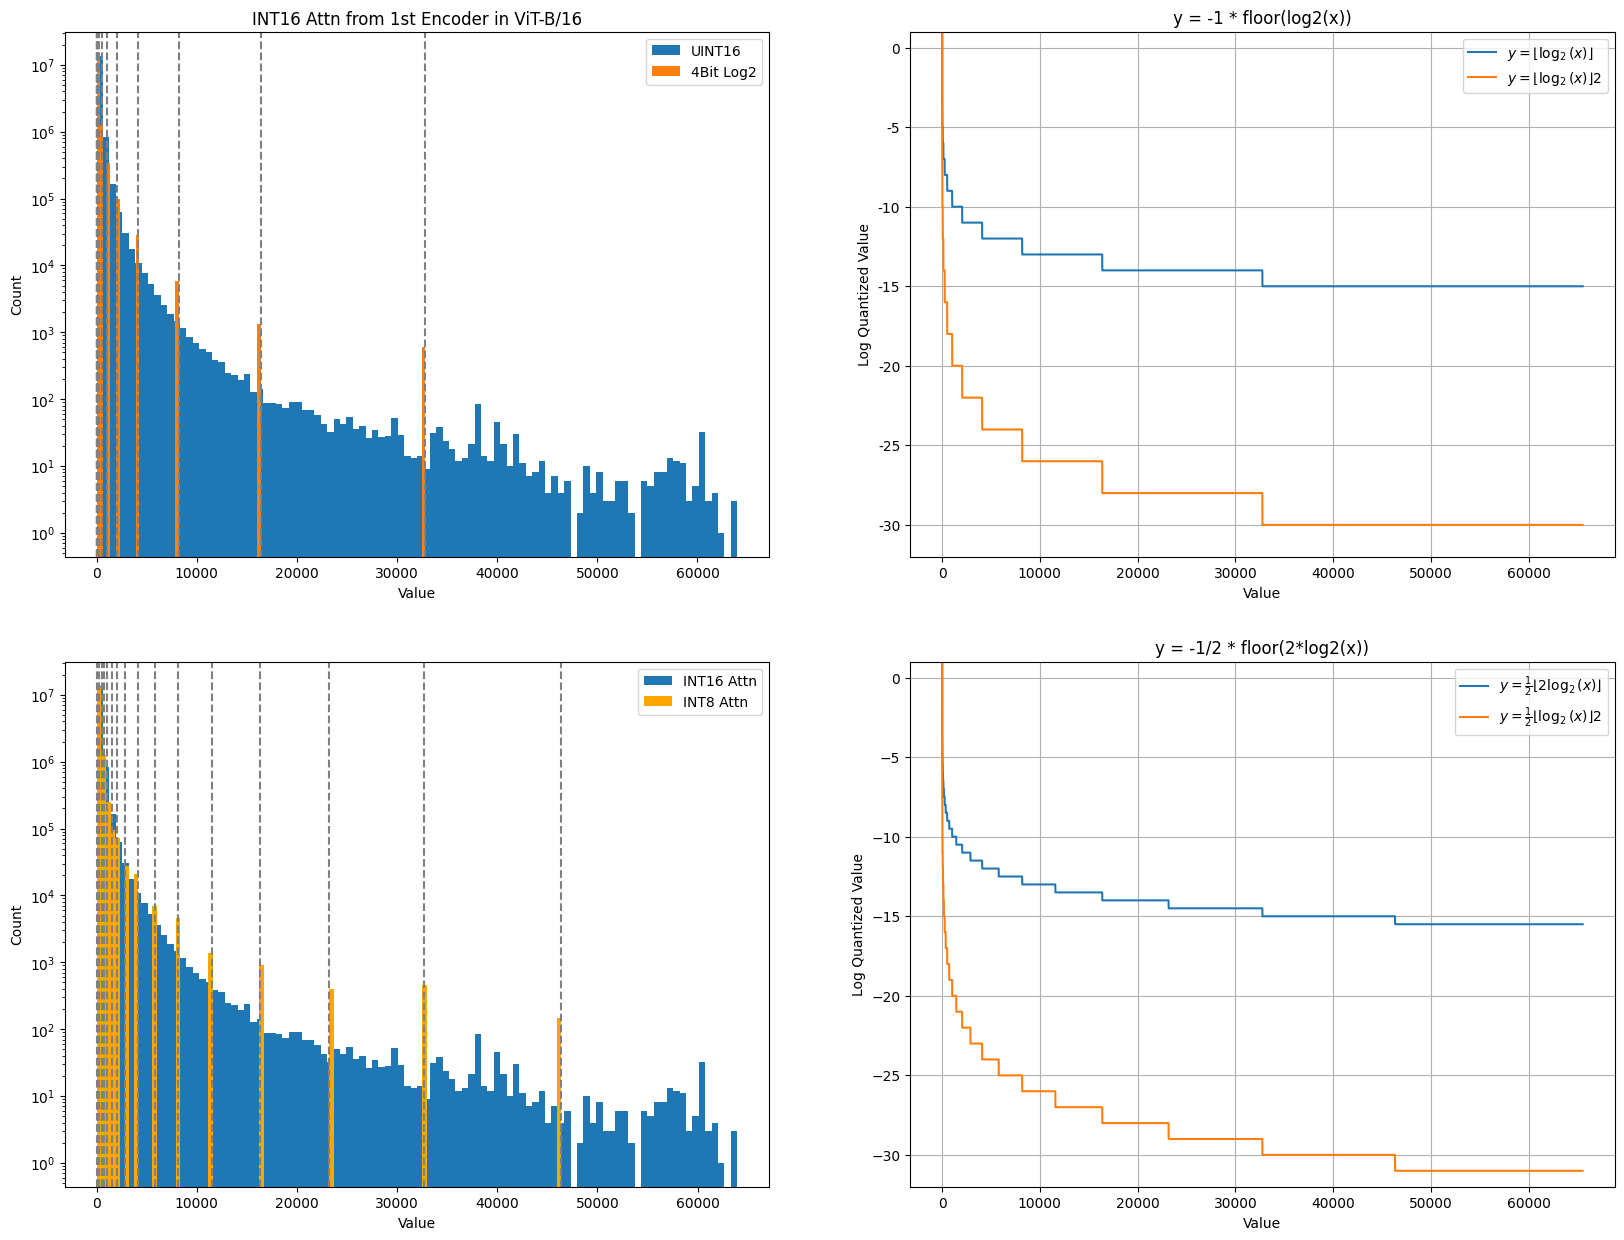

In [173]:

x_int = torch.load('x_int.pt')[:32]
# x_int = torch.load("15entries_xint.pt")[:32]

print(x_int.shape)
# x_int = x_int / x_int.max() * (2**16-2)
print(x_int.min(), x_int.max())



fig, ax = plt.subplots(2, 2, figsize=(20, 15))

"""1st"""
x_log2 = x_int.clone() +1
x_log2_q = -1 * x_log2.log2().floor()

x_log2_dq = 2 ** (-x_log2_q) -1

ax[0][0].hist(x_log2.flatten().cpu().numpy(), bins=100, label="UINT16")
ax[0][0].hist(x_log2_dq.flatten().cpu().numpy(), bins=100, label="4Bit Log2")
ax[0][0].set_title("INT16 Attn from 1st Encoder in ViT-B/16")


""" 2nd"""
x = np.linspace(0.01, 65535, 10000)  # log(x)를 위해 0을 제외하고 설정

y = -1 * (np.floor(np.log2(x)))
ax[0][1].plot(x, y, label=r"$y = {\lfloor\log_2(x)\rfloor} $")
y = -1 * (np.floor(np.log2(x))) * 2
ax[0][1].plot(x, y, label=r"$y = {\lfloor\log_2(x)\rfloor} 2 $")
ax[0][1].set_title("y = -1 * floor(log2(x))")

""" 1, 2 """
x_values = x_log2_dq.unique().cpu().numpy()
for tic in x_values:
    ax[0][0].axvline(x=tic, color="gray", linestyle="--")  # , label=f"x={tic}")
    # ax[0][1].axvline(x=tic, color="gray", linestyle="--")  # , label=f"x={tic}")

""" 3rd"""

pre_bits = torch.tensor(16)
k = torch.tensor(1)
int_bias = torch.tensor(1)

x_int_biased = x_int.clone() + int_bias
x_int_log_q = int_huge_16bit_int_to_log(x_int_biased, k)
x_int_log_dq = int_huge_16bit_log_to_int(x_int_log_q, k)
x_int_log_dq = x_int_log_dq - int_bias

# [5] most biggest 16 values
x_int8_out = (x_int_log_dq / 255).round().clamp(0, 255)
x_int_out = x_int8_out * 255

x_int_hist = x_int.flatten().cpu().numpy()
x_int_out_hist = x_int_out.flatten().cpu().numpy()
ax[1][0].hist(x_int_hist, bins=100, label="INT16 Attn")
ax[1][0].hist(x_int_out_hist, bins=100, color="orange", label="INT8 Attn")


""" 4th"""
x = np.linspace(0.01, 65535, 10000)  # log(x)를 위해 0을 제외하고 설정

y = -1 / 2 * (np.floor(np.log2(x) * 2))
ax[1][1].plot(x, y, label=r"$y = \frac{1}{2}{\lfloor2\log_2(x)\rfloor} $")
y = -1 / 2 * (np.floor(np.log2(x) * 2)) * 2
ax[1][1].plot(x, y, label=r"$y = \frac{1}{2}{\lfloor\log_2(x)\rfloor}2 $")
ax[1][1].set_title("y = -1/2 * floor(2*log2(x))")

"""3, 4"""
x_values = x_int_out.unique().cpu().numpy()
for tic in x_values:
    ax[1][0].axvline(x=tic, color="gray", linestyle="--")#, label=f"x={tic}")
    # ax[1][1].axvline(x=tic, color="gray", linestyle="--")#, label=f"x={tic}")


ax[0][1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))


for i, j in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    if j ==0:
        """for hist"""
        ax[i][j].set_yscale("log")
        ax[i][j].set_ylabel("Count")
    else:
        ax[i][j].set_ylabel("Log Quantized Value")
        ax[i][j].set_ylim(-32, 1)
        ax[i][j].grid(True)
    ax[i][j].legend()
    ax[i][j].set_xlabel("Value")


plt.show()

torch.Size([32, 12, 197, 197])
tensor(0., device='cuda:0') tensor(34034., device='cuda:0')


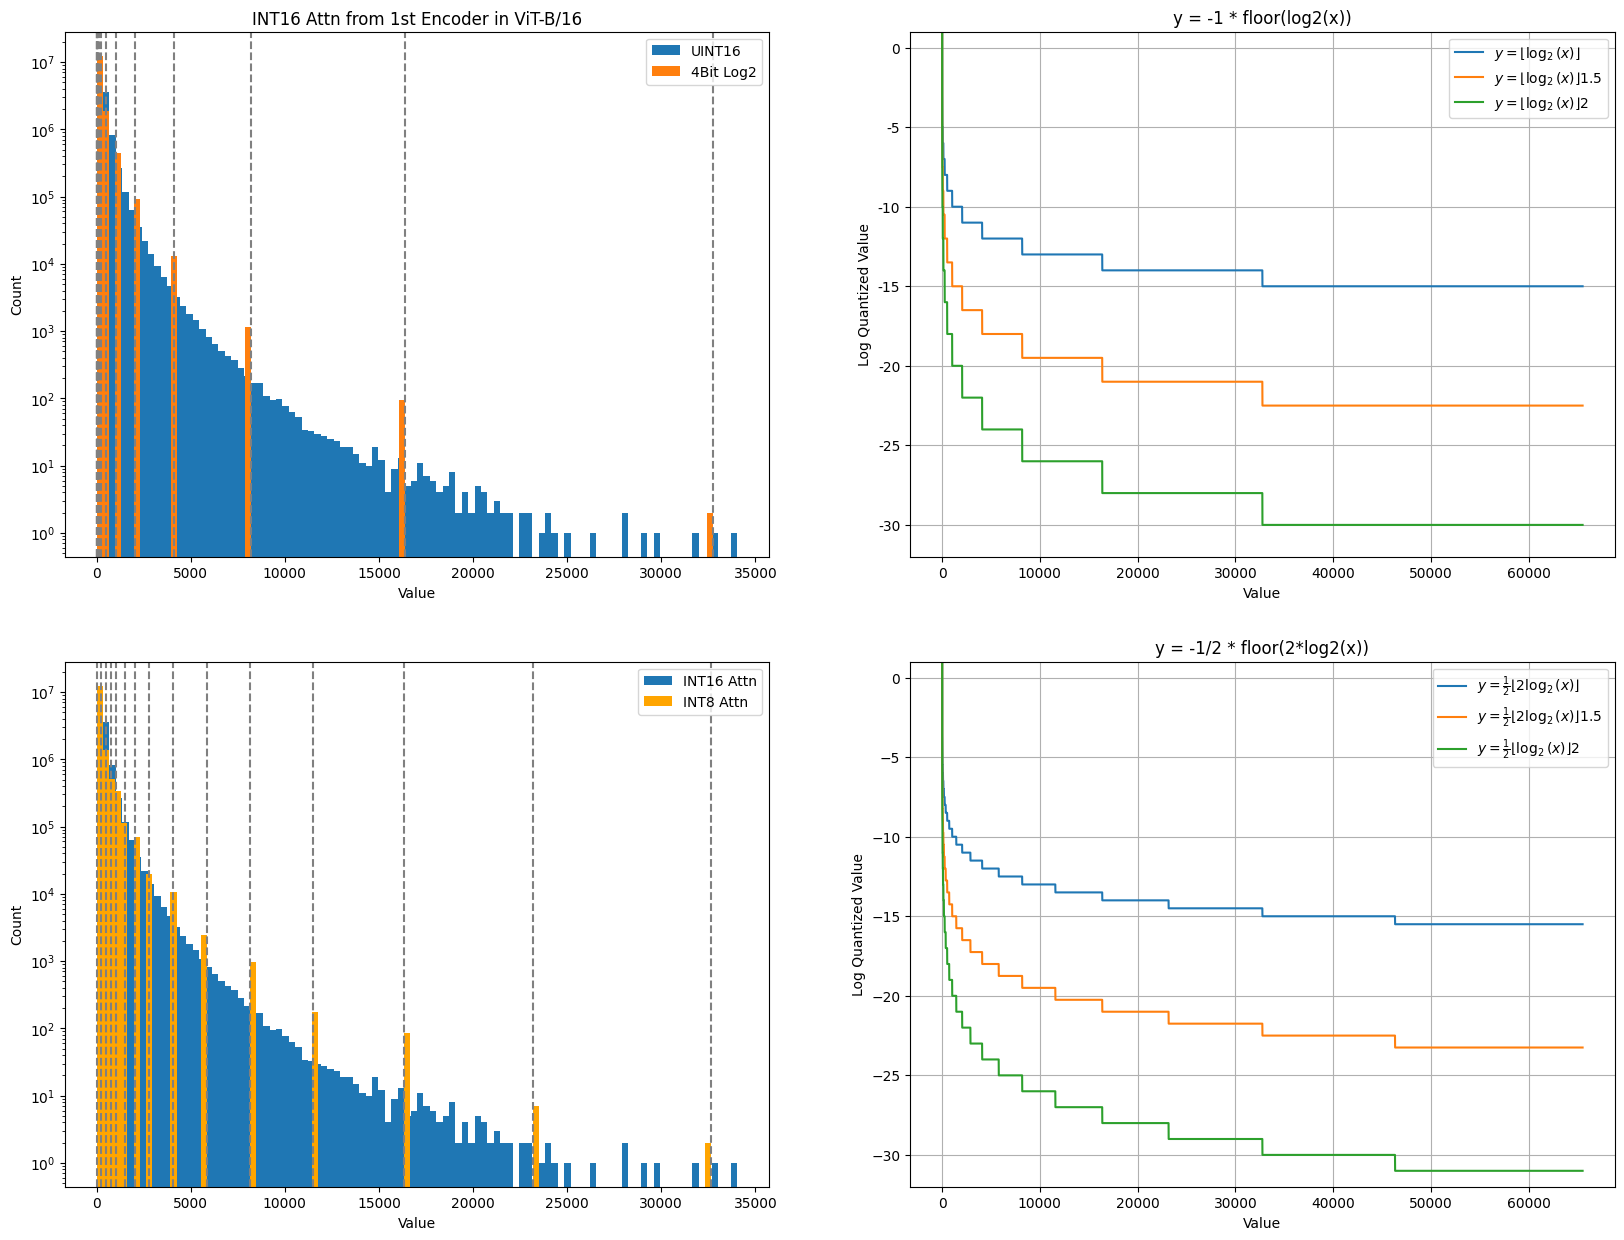

In [177]:
# x_int = torch.load("x_int.pt")[:32]
x_int = torch.load("15entries_xint.pt")[:32]

print(x_int.shape)
# x_int = x_int / x_int.max() * (2**16 - 2)
print(x_int.min(), x_int.max())

fig, ax = plt.subplots(2, 2, figsize=(20, 15))

"""1st"""
x_log2 = x_int.clone() + 1
x_log2_q = -1 * x_log2.log2().floor()

x_log2_dq = 2 ** (-x_log2_q) - 1

ax[0][0].hist(x_log2.flatten().cpu().numpy(), bins=100, label="UINT16")
ax[0][0].hist(x_log2_dq.flatten().cpu().numpy(), bins=100, label="4Bit Log2")
ax[0][0].set_title("INT16 Attn from 1st Encoder in ViT-B/16")


""" 2nd"""
x = np.linspace(0.01, 65535, 10000)  # log(x)를 위해 0을 제외하고 설정

y = -1 * (np.floor(np.log2(x)))
ax[0][1].plot(x, y, label=r"$y = {\lfloor\log_2(x)\rfloor} $")
y = -1 * (np.floor(np.log2(x))) * 1.5
ax[0][1].plot(x, y, label=r"$y = {\lfloor\log_2(x)\rfloor} 1.5 $")
y = -1 * (np.floor(np.log2(x))) * 2
ax[0][1].plot(x, y, label=r"$y = {\lfloor\log_2(x)\rfloor} 2 $")
ax[0][1].set_title("y = -1 * floor(log2(x))")

""" 1, 2 """
x_values = x_log2_dq.unique().cpu().numpy()
for tic in x_values:
    ax[0][0].axvline(x=tic, color="gray", linestyle="--")  # , label=f"x={tic}")
    # ax[0][1].axvline(x=tic, color="gray", linestyle="--")  # , label=f"x={tic}")

""" 3rd"""

pre_bits = torch.tensor(16)
k = torch.tensor(1)
int_bias = torch.tensor(1)

x_int_biased = x_int.clone() + int_bias
x_int_log_q = int_huge_16bit_int_to_log(x_int_biased, k)
x_int_log_dq = int_huge_16bit_log_to_int(x_int_log_q, k)
x_int_log_dq = x_int_log_dq - int_bias

# [5] most biggest 16 values
x_int8_out = (x_int_log_dq / 255).round().clamp(0, 255)
x_int_out = x_int8_out * 255

x_int_hist = x_int.flatten().cpu().numpy()
x_int_out_hist = x_int_out.flatten().cpu().numpy()
ax[1][0].hist(x_int_hist, bins=100, label="INT16 Attn")
ax[1][0].hist(x_int_out_hist, bins=100, color="orange", label="INT8 Attn")


""" 4th"""
x = np.linspace(0.01, 65535, 10000)  # log(x)를 위해 0을 제외하고 설정

y = -1 / 2 * (np.floor(np.log2(x) * 2))
ax[1][1].plot(x, y, label=r"$y = \frac{1}{2}{\lfloor2\log_2(x)\rfloor} $")
y = -1 / 2 * (np.floor(np.log2(x) * 2)) * 1.5
ax[1][1].plot(x, y, label=r"$y = \frac{1}{2}{\lfloor2\log_2(x)\rfloor} 1.5 $")
y = -1 / 2 * (np.floor(np.log2(x) * 2)) * 2
ax[1][1].plot(x, y, label=r"$y = \frac{1}{2}{\lfloor\log_2(x)\rfloor}2 $")
ax[1][1].set_title("y = -1/2 * floor(2*log2(x))")

"""3, 4"""
x_values = x_int_out.unique().cpu().numpy()
for tic in x_values:
    ax[1][0].axvline(x=tic, color="gray", linestyle="--")  # , label=f"x={tic}")
    # ax[1][1].axvline(x=tic, color="gray", linestyle="--")#, label=f"x={tic}")


ax[0][1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))


for i, j in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    if j == 0:
        """for hist"""
        ax[i][j].set_yscale("log")
        ax[i][j].set_ylabel("Count")
    else:
        ax[i][j].set_ylabel("Log Quantized Value")
        ax[i][j].set_ylim(-32, 1)
        ax[i][j].grid(True)
    ax[i][j].legend()
    ax[i][j].set_xlabel("Value")


plt.show()